In [1]:
#import importlib
import bayes_model_summary
import get_data
import numpy as np
import pandas as pa
#\from isoweek import Week
import os
#importlib.reload(get_data)
#importlib.reload(bayes_model_summary)



In [2]:
from get_data import get_data,get_data_withcovid
import pandas as pd
from bayes_model_summary import summarize
from bayes_estimate import estimate_regression
import gc

/root/anaconda3/envs/pymc_env/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/root/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [3]:
import os
def path_creator(path):
    """
    Creates a path of any depth.
    Note the path is created relative to code folder
    Do not start path with '../' - the function will handle that
    Example: 'Model Free/Chicago'
    returns nothing
    """
    
    paths = path.split('/')
    print(paths)
    new_path ='../{}/'
    for p in paths:
        if not os.path.exists(new_path.format(p)):
            new_path = new_path.format(p)
            print(new_path)
            try:
                os.makedirs(new_path.format(p))
            except:
                print(new_path.format(p)," : Already Exists")
            new_path = new_path+'/{}/'
        else:
            new_path = new_path.format(p)
            new_path = new_path+'/{}/'

In [4]:
def estimate(kwargs):
    estimator='bayes'
    f, prior_type, model_type, estimator = kwargs
    
    filename_parts = f.split('/')
    drug_name = filename_parts[-2]
    clean_fname = filename_parts[-1].replace('.csv','') #+ "_" + filename_parts[-2]
    graphs_path, results_path = ( "Processed Data/state_week/synth_data/" +drug_name + "/"  + '/Graphs',  "Processed Data/state_week/synth_data/" +drug_name + "/" +'/Results')
    
    
    path_creator(graphs_path)
    path_creator(results_path)
    
    
    print(clean_fname +'\n')
    print('\n')
    suffix = clean_fname
    
    
    if "claim" in f:
        title = "\n Actual and Predicted Prescription Claims (Indexed) for IVM and Covid Cases"
        y_label = "Indexed Claim Count (IVM)"
    elif 'person' in f:
        title ="\n Actual and Predicted First Person Count (IVM) (Indexed) for IVM and Covid Cases"
        y_label = "Indexed First Person Count (IVM)"    
    elif 'days' in f:
        title ="\n Actual and Predicted Prescription Total Days Supply(Indexed) for IVM and Covid Cases"
        y_label = "Indexed Total Days Supply (IVM)"   
       
    scale= True
    
    #title.replace("_","")
    X_all,y_all,X_train, y_train,y_scaler,time_labels, covid_cases, skip = get_data_withcovid(f,scale=scale,remove={'trend', 'y','Unnamed: 0','pre_period','time_index','treat_post','year','week','trend', 'covid_cases','week_date'}, model_type=model_type)
    #trace,model_preds,model,posterior_predictive,selected_init_method,cv_mape= estimate_regression(X_train, y_train, X_all, y_all,prior_type,model_type,relaxed=False, estimator=estimator, y_scaler=None)
    #print(covid_cases)
    #stop
    if skip:
        return {'inestimable': clean_fname}
    vlinepos=[y_train.shape[0],y_train.shape[0]+12]
    
    
    print(vlinepos)
    try:
        trace,model_preds,model,posterior_predictive,selected_init_method,cv_mape= estimate_regression(X_train, y_train, X_all, y_all,prior_type,model_type,relaxed=False, estimator=estimator, y_scaler=None)
    
    except:
        return {'inestimable': clean_fname}
    
    # covid_blue = pd.read_csv("Data_IB/Covid_national_blue.csv")
    #covid_cases=None
    summary= summarize(trace,model, model_preds, clean_fname, model_type,prior_type, y_all, y_train,y_scaler, suffix+'_{}'.format(prior_type),xname='Weeks',covid_cases=covid_cases, estimator=estimator,selected_init_method=selected_init_method,cv_mape = cv_mape,opath='../'+graphs_path, time_labels=time_labels, vlinepos=vlinepos, title=title, y_label=y_label, national=True,transform=False, drug_name=drug_name)
    df = pd.DataFrame.from_dict([summary])
    df.to_csv('../'+results_path +"/"+ suffix+'_untransformed' + ".csv")
    summary= summarize(trace,model, model_preds, clean_fname, model_type,prior_type, y_all, y_train,y_scaler, suffix+'_{}'.format(prior_type),xname='Weeks',covid_cases=covid_cases, estimator=estimator,selected_init_method=selected_init_method,cv_mape = cv_mape,opath='../'+graphs_path+"_stdz", time_labels=time_labels, vlinepos=vlinepos, title=title, y_label=y_label, national=True,transform=True, drug_name=drug_name)
    df = pd.DataFrame.from_dict([summary])
    df.to_csv('../'+results_path +"/"+ suffix+'_standardized' + ".csv")
    
    gc.collect()
    return {'estimable': clean_fname, "model_preds": model_preds, "y_scaler" : y_scaler, }

In [5]:
import glob

In [9]:
#filenames = glob.glob("../Data_IB/data_preprocessed_full/states/TotalClaims/*.csv")

#filenames = glob.glob("../Processed Data/state_week/synth_data/ivermectin/*.csv")
filenames = glob.glob("../Processed Data/state_week/synth_data/ivermectin/*.csv")

In [10]:
filenames =[f for f in filenames if "placebo" not in f and "claim" in f and "orig" not in f and "all" in f and ('gpi' in f or 'covid' in f)]

In [11]:
filenames

['../Processed Data/state_week/synth_data/ivermectin/actual_claim_count_all_covid.csv',
 '../Processed Data/state_week/synth_data/ivermectin/actual_claim_count_all_gpi.csv']

In [12]:
#len(filenames)

In [13]:
import glob
from itertools import repeat
from random import shuffle
# filenames = glob.glob('../Processed Data/modeling_data/rotate_gh/**/RT*.csv', recursive=True)

# filenames = [x for x in filenames if 'long' in x or 'hand' in x]
#filenames = ["Data_IB/data_preprocessed_full/national/FirstTime/" + file for file in files]
results=[]
suffix = 'hcq'
prior_type = 'Finnish'
model_type = 'Linear'
inestimable=[]
results  = []
estimator='bayes'

In [14]:
from itertools import product

def get_kwargs(filenames,prior_type, model_type, estimator, vlinepos=[]):
    prior_types= [prior_type] #,'Hyperlasso',
    cartesian = list(product(filenames,prior_types))
    files = [x[0] for x in cartesian]
    priors = [x[1] for x in cartesian]
    process_this= zip(files, priors, repeat(model_type), repeat(estimator), repeat(vlinepos) )
    return process_this

In [15]:
filenames[0].split('/')

['..',
 'Processed Data',
 'state_week',
 'synth_data',
 'ivermectin',
 'actual_claim_count_all_covid.csv']

In [16]:
filenames[0]

'../Processed Data/state_week/synth_data/ivermectin/actual_claim_count_all_covid.csv'

[{'estimable': 'actual_claim_count_all_covid', 'model_preds': array([[-0.47174459, -1.13005588, -1.0882418 , ...,  2.18096511,
         0.06224998, -0.31087241],
       [-1.40003754, -1.07241617, -0.8168419 , ...,  3.02984166,
         1.55825944,  2.16694597],
       [-0.54459396, -0.75643926, -0.73243638, ...,  2.32892843,
         0.34856271, -0.19698103],
       ...,
       [-0.26305209, -1.01431246, -1.27379665, ...,  6.19418682,
         3.14579037,  4.52503842],
       [-1.26821314, -1.23492785, -1.40369829, ...,  3.8303807 ,
         1.54317234,  1.21212651],
       [-0.76246724, -1.15677478, -1.55953082, ...,  3.10665012,
         1.1549768 ,  1.43029637]]), 'y_scaler': StandardScaler()}, {'estimable': 'actual_claim_count_all_gpi', 'model_preds': array([[-1.03157976, -0.83983295, -1.14406306, ...,  4.49322977,
         2.41736051,  2.30082983],
       [-0.97943532, -0.82302473, -0.44844035, ...,  4.43223687,
         2.72401138,  2.9708017 ],
       [-0.90349872, -0.70441331, 

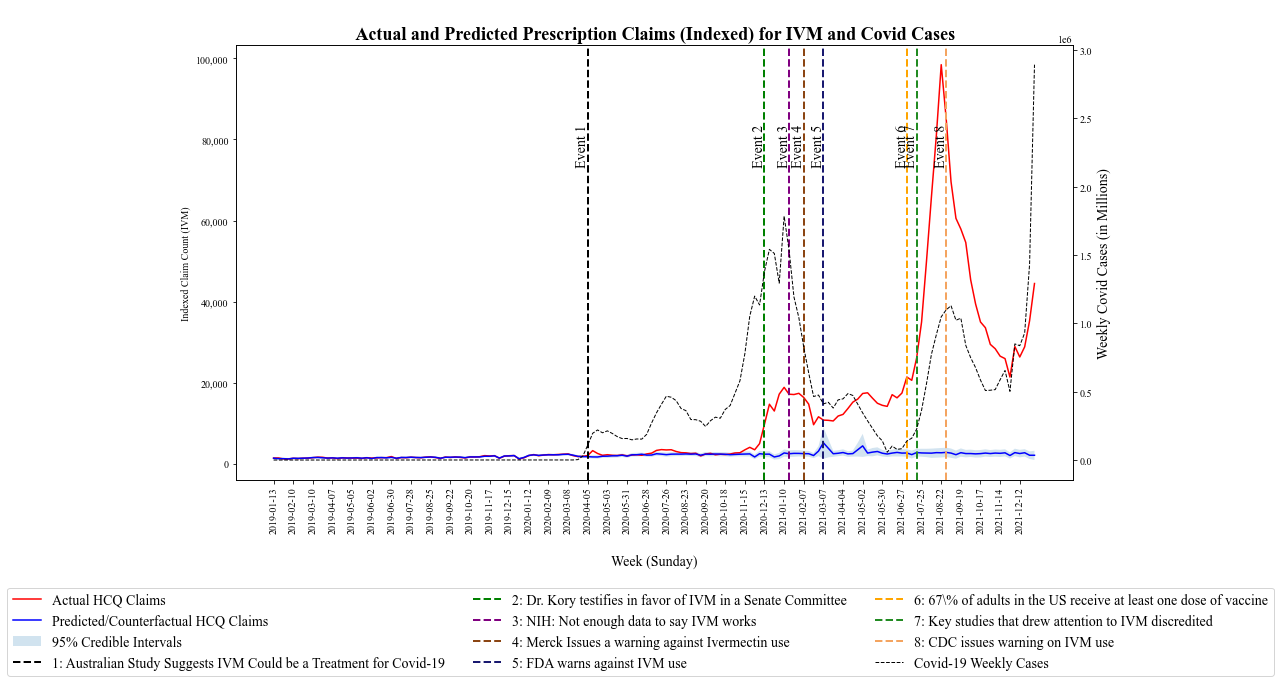

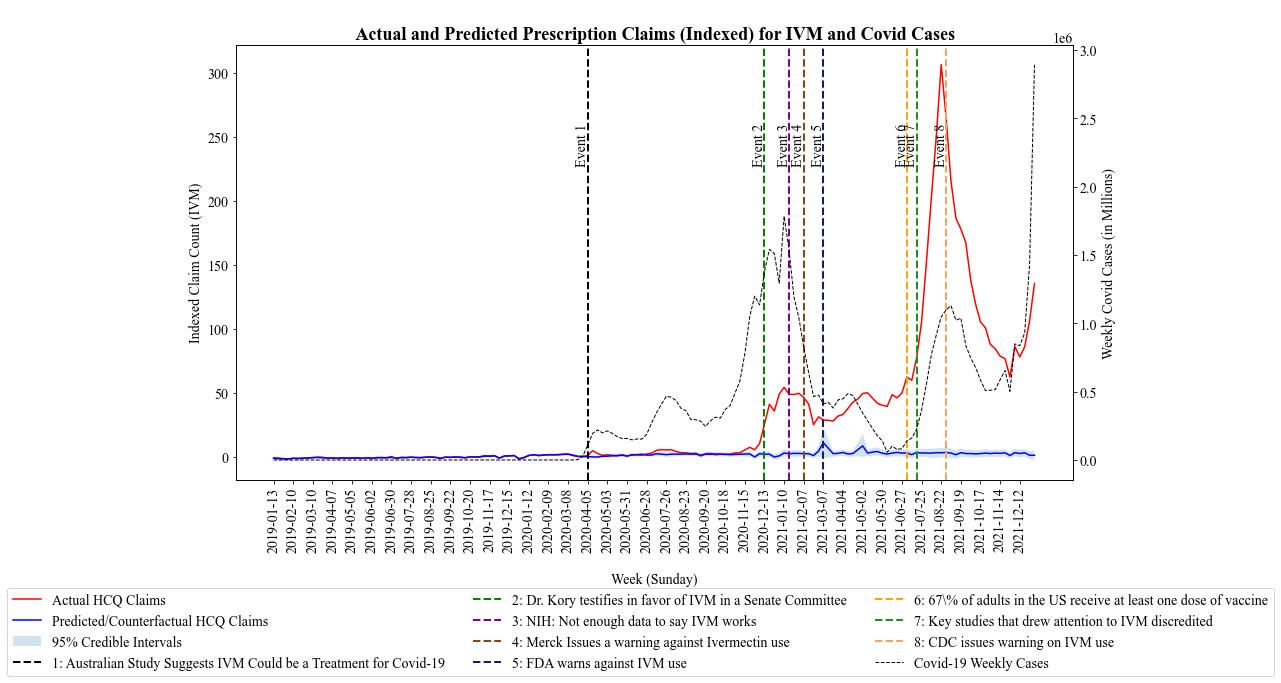

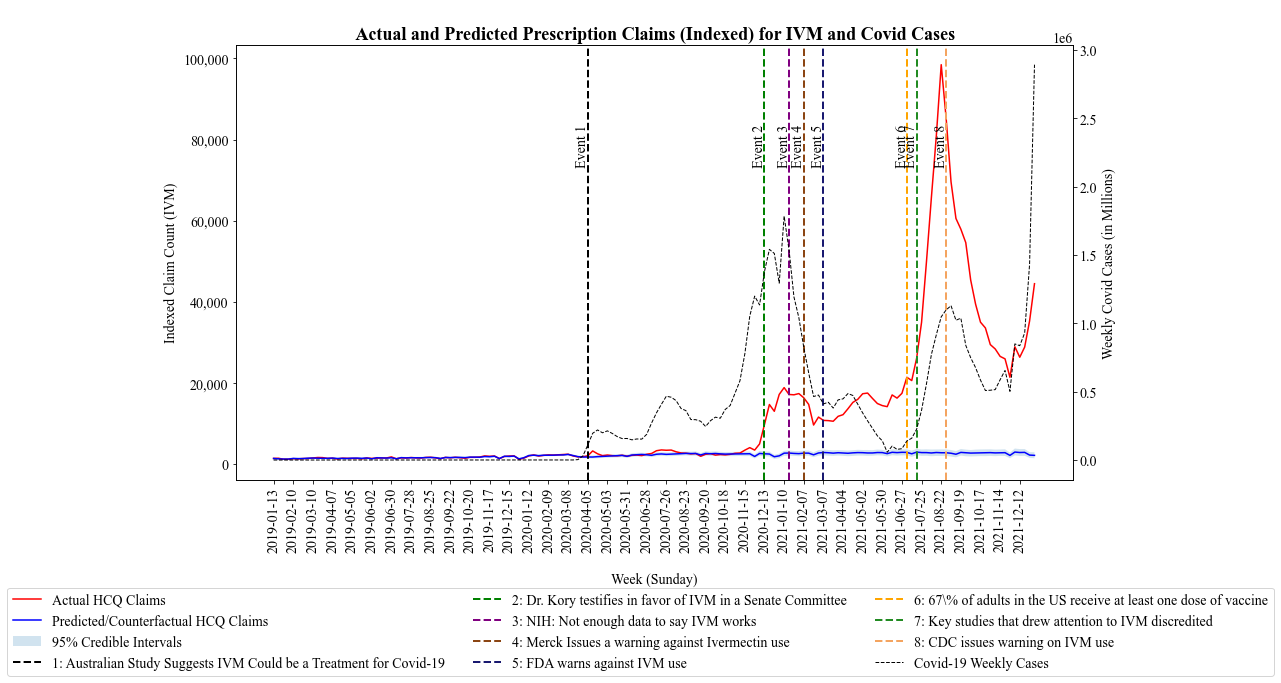

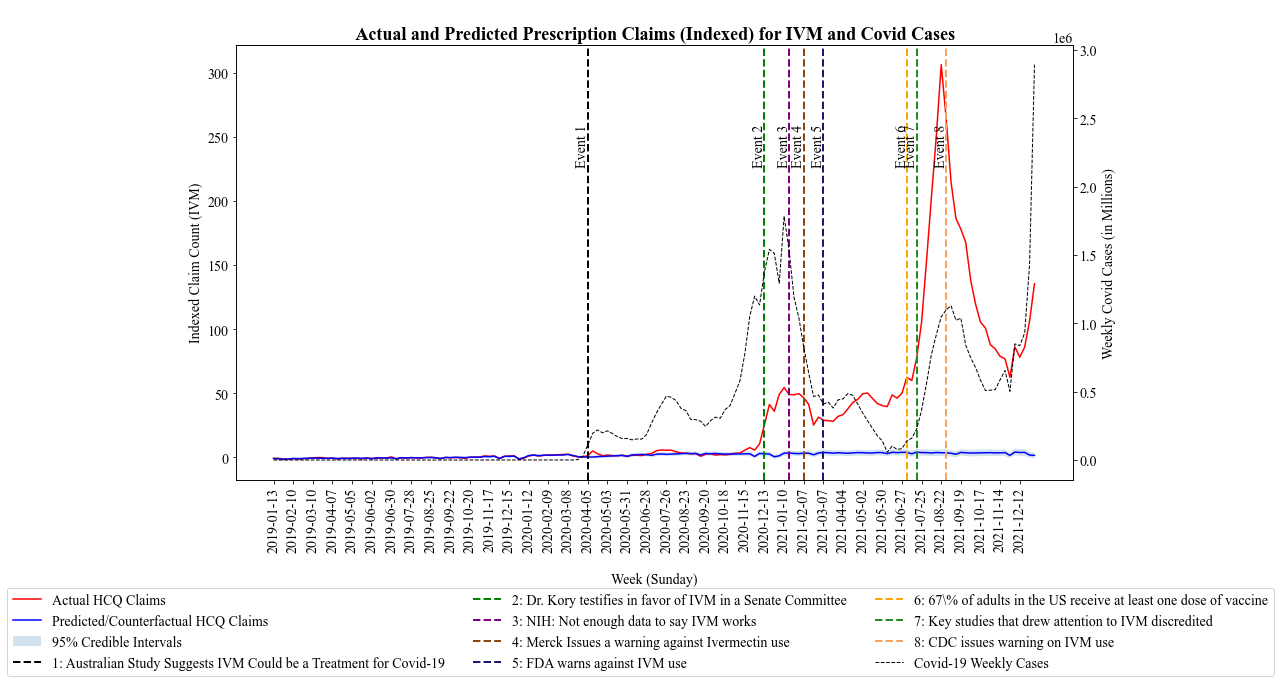

In [17]:
skipper=[]
#%%time
from IPython.display import clear_output
for ix,f in enumerate(filenames):
    print(ix,"   :   ",f)
    akwarg= [f,'Spikeslab','Linear','bayes']
    skipper.append(estimate(akwarg))
    clear_output(wait=True)

print(skipper)